# Data
- Lead scoring dataset from UCI
    - https://archive.ics.uci.edu/dataset/222/bank+marketing

# Methods
- Feature Engineering
    - One hot encoded categorical features
    - Used SMOTE oversampling to generate more samples for minority class 
    - Scaled numerical features to have mean of 0 and variance of 1
- Model
    - Logistic regression
    - Grid search and cross validation for choosing parameters
    - L1 regularization used for feature selection
    - Calibration of model checked to make sure the output probabilities would be interpretable (predicted probability of 0.80 roughly represents an 80% chance of lead being converted)

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("data/raw/bank-additional/bank-additional-full.csv", delimiter=";")

In [4]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [5]:
df = df.drop(columns=["duration", "previous", "poutcome"])

In [6]:
cat_cols = ["job", "marital", "education", "default", 
            "housing", "loan", "contact", "month", 
            "day_of_week", "poutcome"]
num_cols = df.columns.difference(cat_cols + ["y"]).tolist()
for c in cat_cols:
    print(f"{c}: {len(df[c].unique())} categories")

job: 12 categories
marital: 4 categories
education: 8 categories
default: 3 categories
housing: 3 categories
loan: 3 categories
contact: 2 categories
month: 10 categories
day_of_week: 5 categories
poutcome: 3 categories


In [7]:
df[num_cols].describe()

,age,campaign,cons.conf.idx,cons.price.idx,emp.var.rate,euribor3m,nr.employed,pdays
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,-40.502600,93.575664,0.081886,3.621291,5167.035911,962.475454
std,10.42125,2.770014,4.628198,0.578840,1.570960,1.734447,72.251528,186.910907
min,17.00000,1.000000,-50.800000,92.201000,-3.400000,0.634000,4963.600000,0.000000
25%,32.00000,1.000000,-42.700000,93.075000,-1.800000,1.344000,5099.100000,999.000000
50%,38.00000,2.000000,-41.800000,93.749000,1.100000,4.857000,5191.000000,999.000000
75%,47.00000,3.000000,-36.400000,93.994000,1.400000,4.961000,5228.100000,999.000000
max,98.00000,56.000000,-26.900000,94.767000,1.400000,5.045000,5228.100000,999.000000


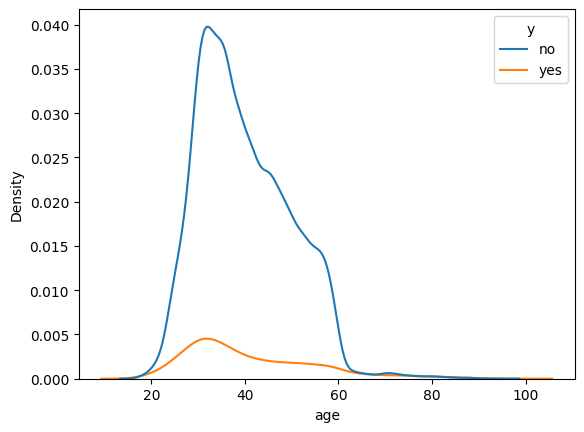

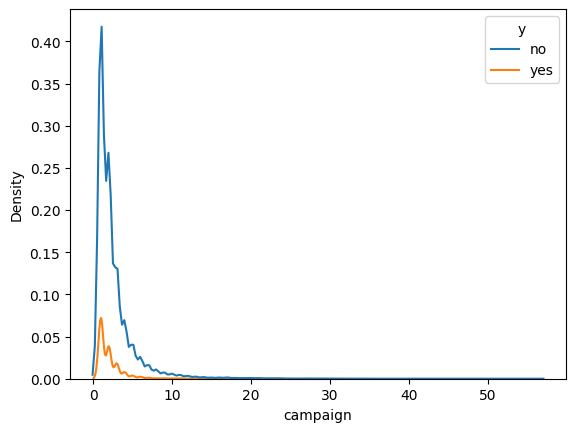

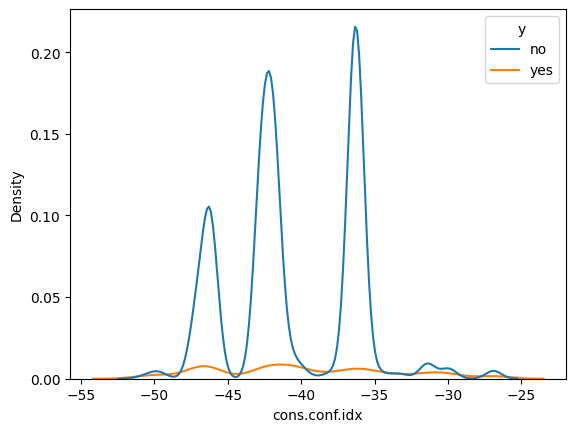

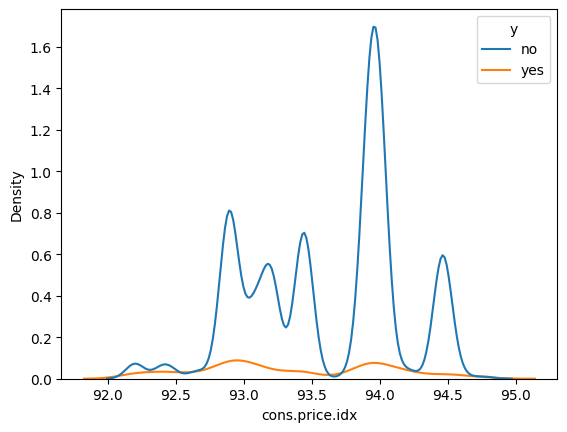

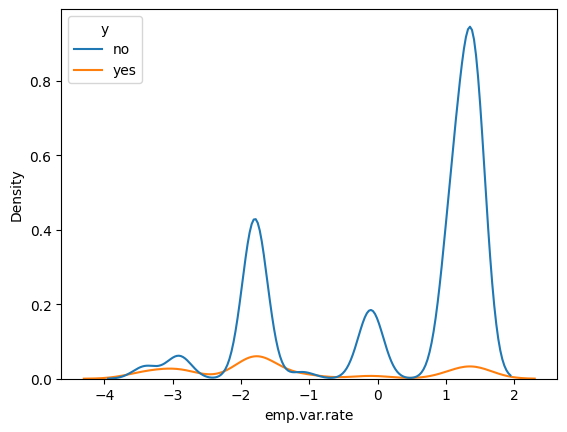

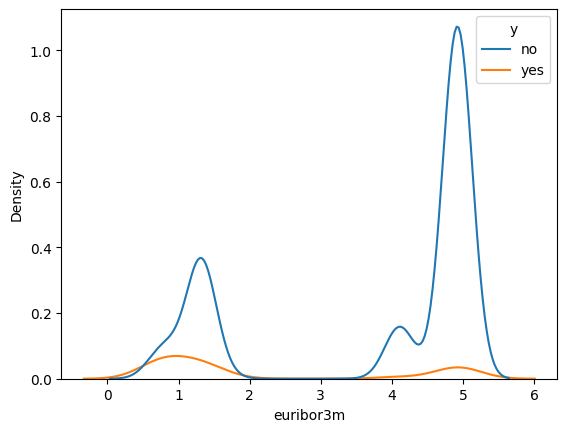

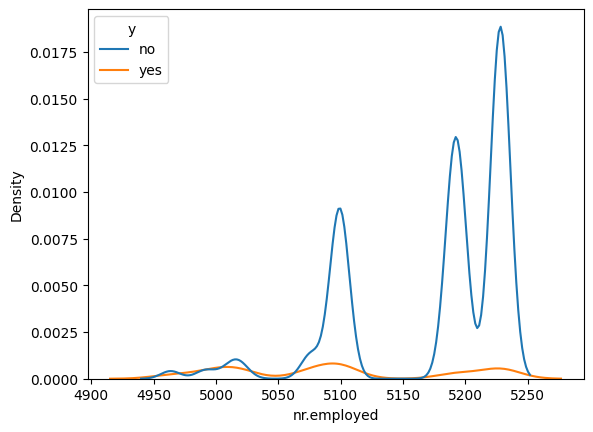

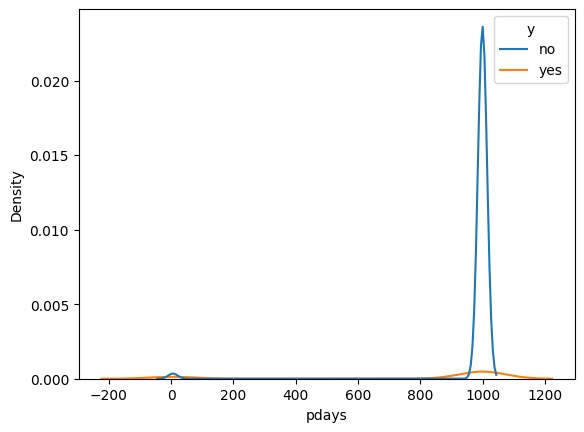

In [8]:
for n in num_cols:
    plt.figure()
    sns.kdeplot(df, x=n, hue="y")

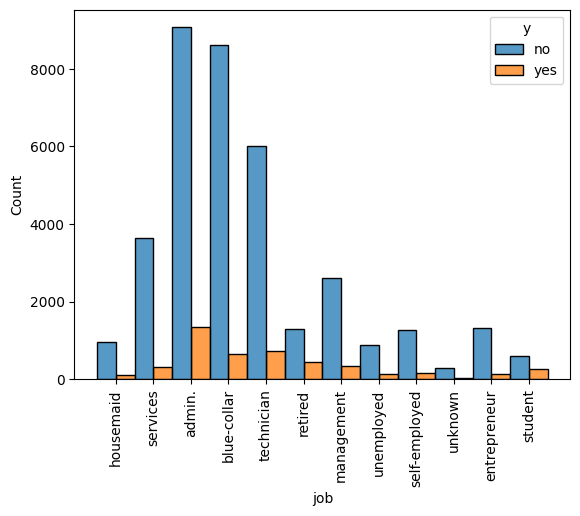

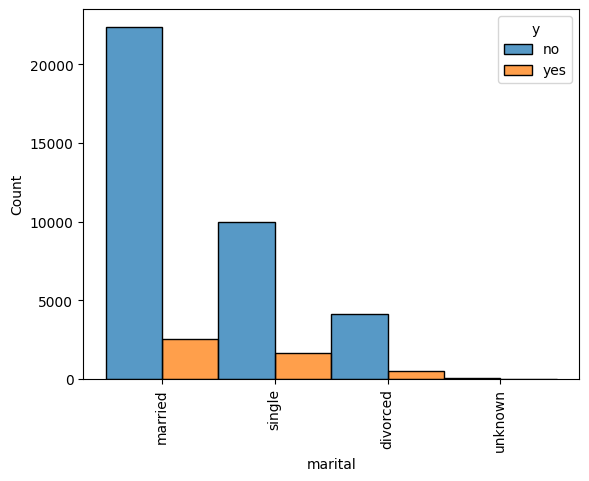

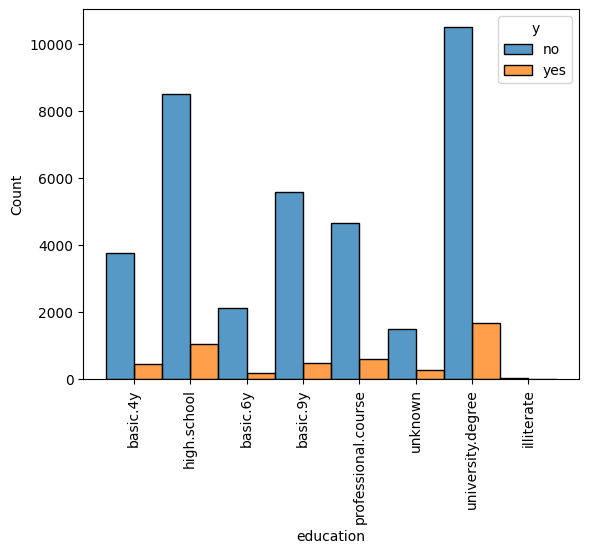

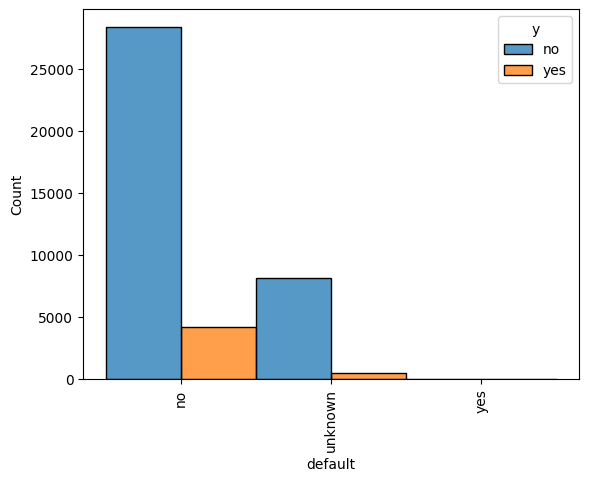

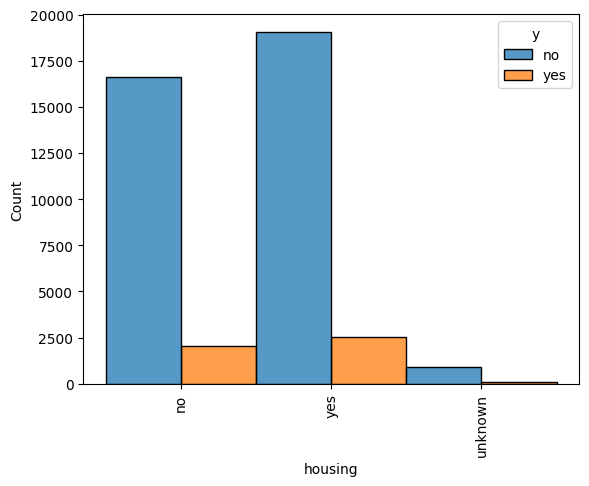

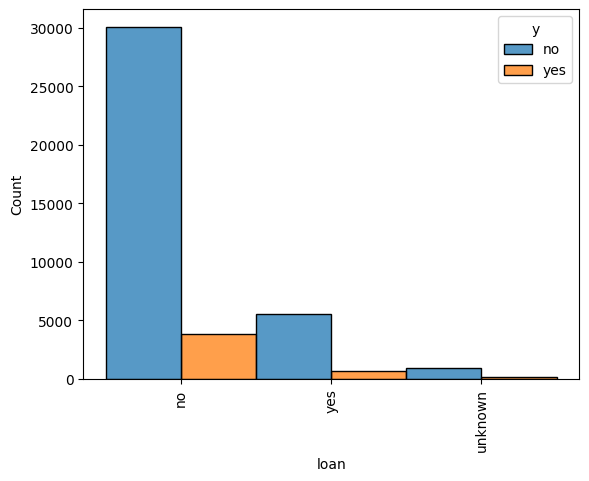

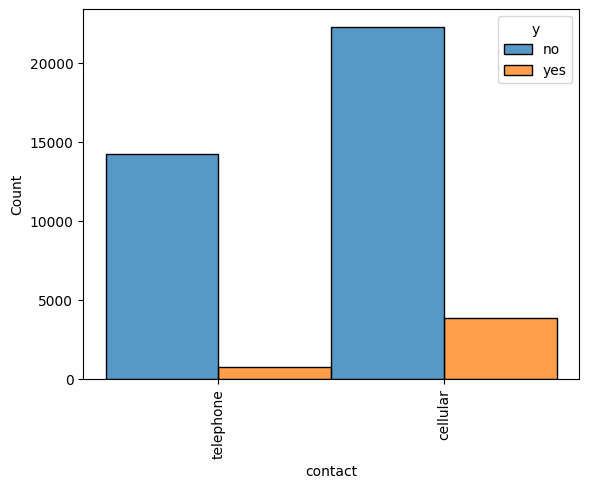

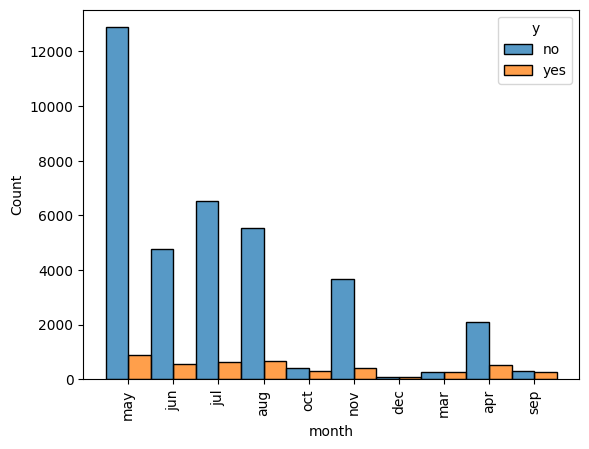

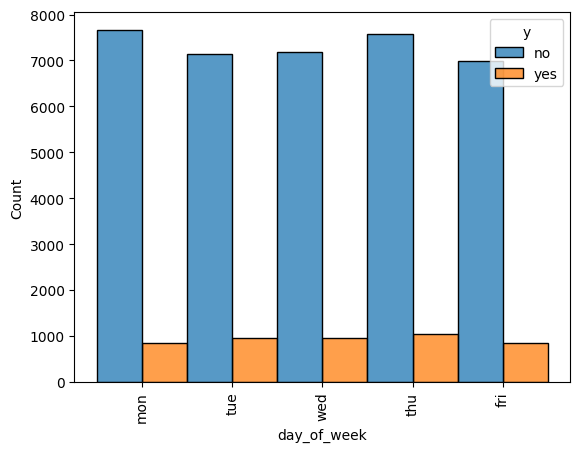

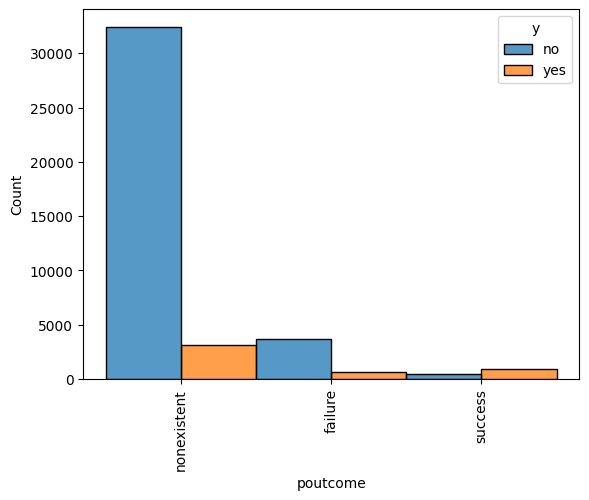

In [9]:
for n in cat_cols:
    plt.figure()
    plt.xticks(rotation=90)
    sns.histplot(df, x=n, hue="y", multiple="dodge")

In [10]:
ohe = OneHotEncoder(sparse_output=False)
ohe_features = ohe.fit_transform(df[cat_cols])
ohe_cat_features = pd.DataFrame(ohe_features, columns=ohe.get_feature_names_out().tolist())
data = pd.concat([df[num_cols], ohe_cat_features], axis=1)

In [11]:
sm = SMOTE()
x_sm, y_sm = sm.fit_resample(data, df["y"])

In [12]:
x_sm_train, x_sm_test, y_sm_train, y_sm_test = train_test_split(data, df["y"], test_size=0.3)
ct = ColumnTransformer([
        ('scaler', StandardScaler(), num_cols)
    ], remainder='passthrough')

x_train_sm_scaled = ct.fit_transform(x_sm_train)
x_test_sm_scaled = ct.transform(x_sm_test)

In [13]:
params_sm = {
    "penalty": ["l1"],
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "solver": ["saga"],
    "max_iter": [500]
}
lr_sm = LogisticRegression()
model_sm = GridSearchCV(lr_sm, params_sm, scoring='roc_auc')
model_sm.fit(x_train_sm_scaled, y_sm_train)

/home/colin/Projects/hotel_engine_interview/.he_venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/colin/Projects/hotel_engine_interview/.he_venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/colin/Projects/hotel_engine_interview/.he_venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/colin/Projects/hotel_engine_interview/.he_venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/colin/Projects/hotel_engine_interview/.he_venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: T

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [500],
                         'penalty': ['l1'], 'solver': ['saga']},
             scoring='roc_auc')

In [14]:
model_sm.best_params_

{'C': 0.1, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}

/tmp/ipykernel_798055/3992833380.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=5)


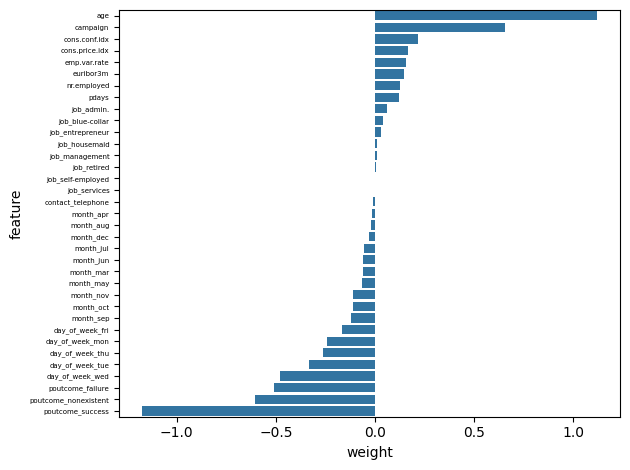

In [44]:
feature_coeff = model_sm.best_estimator_.coef_
feature_weights = pd.DataFrame({
        "feature": data.columns,
        "weight": np.sort(feature_coeff)[0][::-1]
    })
ax = sns.barplot(
    feature_weights[np.abs(feature_weights["weight"]) > 1e-6],
    y = "feature",
    x = "weight",
    orient="h"
)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=5)
plt.tight_layout()
plt.show()

In [16]:
y_sm_pred = model_sm.best_estimator_.predict_proba(x_test_sm_scaled)
roc_auc_score(y_sm_test, y_sm_pred[:,-1])

0.7932616178651929

<Axes: >

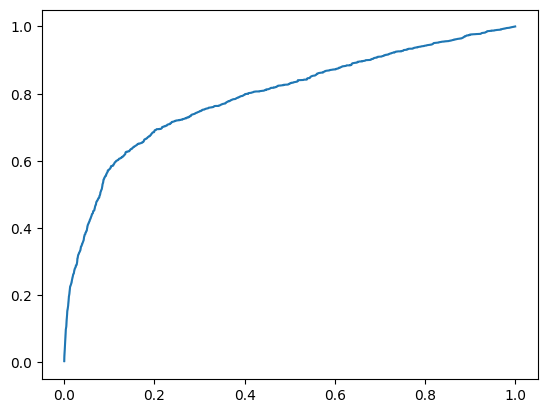

In [17]:
fpr, tpr, score = roc_curve(y_sm_test, y_sm_pred[:,-1], pos_label="yes")
sns.lineplot(x=fpr, y=tpr)

<Axes: ylabel='Count'>

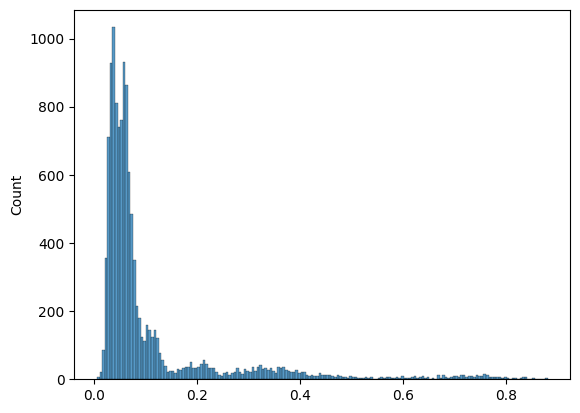

In [18]:
sns.histplot(y_sm_pred[:, 1])

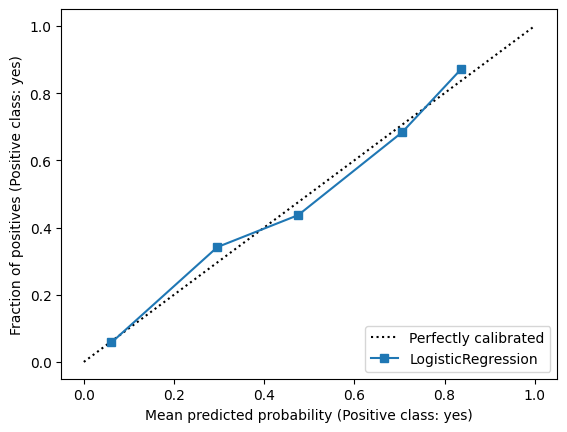

In [19]:
CalibrationDisplay.from_estimator(model_sm.best_estimator_, x_test_sm_scaled, y_sm_test)